In [93]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from matplotlib import image as IMG
import imageio
from PIL import Image
import torchvision as tv
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.transform import rescale, resize, downscale_local_mean
from pathlib import Path

In [94]:
if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

In [95]:
images_path = 'chexpertData_new/'
labels_path = 'train_new.csv'
test_path = 'test_new.csv'

In [96]:
train_df = pd.read_csv(labels_path)
#train_df

In [97]:
frontal = list(map(str, train_df[train_df['label']=='frontal']['target_name'])) 
lateral = list(map(str, train_df[train_df['label']=='lateral']['target_name']))

In [98]:
images = np.concatenate([frontal, lateral])
image_names = []
image_labels = {}

for image in images:
    image_name = images_path + '/' + image
    if image in frontal:
        image_labels.update({image_name: 1})
    else:
        image_labels.update({image_name: 0})
    image_names.append(image_name)

In [99]:
##SERGE
from tqdm import tqdm

import cv2
resized_images = {}
for image_name in tqdm(image_names):
  image = cv2.imread(image_name, 0)
  resized_image = cv2.resize(image, (64, 64))
  resized_images[image_name] = resized_image

100%|██████████| 3199/3199 [01:19<00:00, 40.14it/s]


(64, 64)


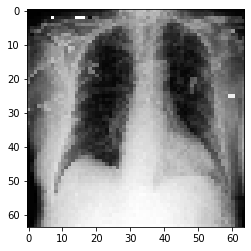

In [100]:
for i, k in enumerate(resized_images):
    if i == 0:
        print(resized_images[k].shape)
        plt.imshow(resized_images[k], cmap='gray')
        break

In [101]:

##SERGE

class LungsClassificationDataset(Dataset):
    def __init__(self, image_names, resized_images, image_labels):
        self.image_names = image_names
        self.resized_images = resized_images
        self.image_labels = image_labels
                                            
    def __len__(self):
        return len(self.image_names)
        
    def __getitem__(self, index):
        image_path = self.image_names[index]

        image_0 = self.resized_images[image_path]
        label = self.image_labels[image_path]

        image = torch.tensor(image_0)
        label = torch.tensor(label)
  
        return {'image':image, 'label':label}

In [102]:
train_image_names, val_image_names = train_test_split(image_names, test_size=0.2)

train = LungsClassificationDataset(train_image_names, resized_images, image_labels)
validation = LungsClassificationDataset(val_image_names, resized_images, image_labels)

In [103]:
imageWidth, imageHeight = train[0]['image'].shape

tensor(1)


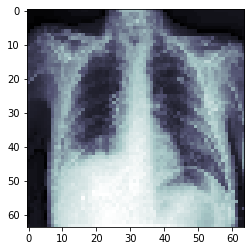

In [104]:

sample = train[5]
plt.imshow(sample['image'], cmap='bone')
print(sample['label'])

In [105]:
class LungModel(nn.Module):
    def __init__(self,width,height): 
        super(LungModel,self).__init__()  

        numConvs1 = 8
        numConvs2 = 16
        numConvs3 = 32
        numConvs4 = 64
        numConvs5 = 256
        convSize = 3
       
        self.cnv1 = nn.Conv2d(in_channels=1, out_channels=numConvs1, kernel_size=convSize)
        self.cnv2 = nn.Conv2d(in_channels=numConvs1, out_channels=numConvs2, kernel_size=convSize)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnv3 = nn.Conv2d(in_channels=numConvs2, out_channels=numConvs3, kernel_size=convSize)
        self.cnv4 = nn.Conv2d(in_channels=numConvs3, out_channels=numConvs4, kernel_size=convSize)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2d = nn.Dropout2d(0.25)
        self.cnv5 = nn.Conv2d(in_channels=numConvs4, out_channels=numConvs4, kernel_size=convSize)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        denseSize1 = 512
        denseSize2 = 100
      
        self.dense1 = nn.Linear(64*13*13, denseSize1)
        self.dense2 = nn.Linear(denseSize1, denseSize2)
        self.dense3 = nn.Linear(denseSize2, 1)
        self.dropout = nn.Dropout(0.25)

    def forward(self,x):

        #print(self.cnv1(x).shape)
        x = F.elu(self.cnv1(x))
        x = F.elu(self.cnv2(x))
        #print(self.maxpool1(x).shape)
        x = self.maxpool1(x)
        #x = self.dropout2d(x)
        #print(self.cnv2(x).shape)
        x = F.elu(self.cnv3(x))
        x = F.elu(self.cnv4(x))
        #print(self.maxpool2(x).shape)
        x = self.maxpool2(x)
        #print(self.dropout2d(x).shape)
        #x = self.dropout2d(x)
        #x = F.elu(self.cnv5(x))
        #print(self.maxpool3(x).shape)
        #x = self.maxpool3(x)
        x = x.view(-1,self.num_flat_features(x))
        #print(self.dense1(x).shape)
        x = F.elu(self.dense1(x)) 
        x = self.dropout(x)
        x = F.elu(self.dense2(x)) 
        x = self.dropout(x)
        x = self.dense3(x)        
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [106]:
model = LungModel(imageWidth, imageHeight).to(dev)

In [107]:
train_loader = DataLoader(train, batch_size=50, shuffle=True, drop_last=True)
val_loader = DataLoader(validation, batch_size=50, shuffle=True, drop_last=True)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [108]:
import time
print(time.time())

1596741423.71004


In [109]:
num_epochs = 10

t = time.time() 

for epoch in range(num_epochs):

    model.train()
    train_loss = 0
    time_start = time.time()

    for sample_idx, sample in enumerate(train_loader):
        image, label = sample['image'].unsqueeze(1).float(), sample['label'].unsqueeze(1).float()
        image, label = image.to(dev), label.to(dev)

        prediction = model(image)

        optimizer.zero_grad()
        loss = criterion(prediction, label)
        loss.backward()
        optimizer.step() 

        train_loss += loss.item()

        if sample_idx % 100 == 0:
            print(loss.item())

    val_loss = 0
    model.eval()

    with torch.no_grad():
        for sample in val_loader:
            image, label = sample['image'].unsqueeze(1).float(), sample['label'].unsqueeze(1).float()
            image, label = image.to(dev), label.to(dev)
            prediction = model(image)

            optimizer.zero_grad()
            loss = criterion(prediction, label)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f"Epoch: {epoch}; Time Epoch: {time.time() - time_start}\nTraining Loss: {train_loss}\nValidation Loss: {val_loss}\n-----")

0.7575679421424866
Epoch: 0; Time Epoch: 0.3912975788116455
Training Loss: 0.2647750060274905
Validation Loss: 0.047160186824233584
-----
0.00624822499230504
Epoch: 1; Time Epoch: 0.38092041015625
Training Loss: 0.03513558234508131
Validation Loss: 0.026843013600834336
-----
0.0021380027756094933
Epoch: 2; Time Epoch: 0.36664628982543945
Training Loss: 0.017397430174705554
Validation Loss: 0.020919846448426444
-----
0.0026189570780843496
Epoch: 3; Time Epoch: 0.36840271949768066
Training Loss: 0.011031482371560973
Validation Loss: 0.025065637559843406
-----
0.0008351178839802742
Epoch: 4; Time Epoch: 0.36649322509765625
Training Loss: 0.004691209789027697
Validation Loss: 0.02337276848023369
-----
0.0001941434311447665
Epoch: 5; Time Epoch: 0.3716142177581787
Training Loss: 0.00394605449714707
Validation Loss: 0.022362871260459844
-----
0.0017493311315774918
Epoch: 6; Time Epoch: 0.3701462745666504
Training Loss: 0.001579168527385656
Validation Loss: 0.01922262089688805
-----
0.0002970

In [110]:
test_df = pd.read_csv(test_path)
test_df


,Unnamed: 0,target_name
0,2164,patient01756study2view1.png
1,773,patient04789study1view2.png
2,1031,patient06246study6view2.png
3,853,patient05235study3view2.png
4,95,patient00636study1view2.png
...,...,...
795,1103,patient06693study1view2.png
796,580,patient03589study1view2.png
797,958,patient05810study3view2.png
798,811,patient05029study4view2.png


In [111]:
images = list(map(str, test_df['target_name']))
test_image_names = []

for image in images:
    image_name = images_path + '/' + image
    test_image_names.append(image_name)

In [112]:

nTestData = len(test_image_names)

In [113]:
resized_images = {}

for image_name in tqdm(test_image_names):
  image = cv2.imread(image_name, 0)
  resized_image = cv2.resize(image, (64, 64))
  resized_images[image_name] = resized_image

100%|██████████| 800/800 [00:19<00:00, 40.15it/s]


(64, 64)


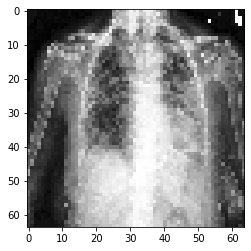

In [114]:
for i, k in enumerate(resized_images):
    if i == 0:
        print(resized_images[k].shape)
        plt.imshow(resized_images[k], cmap='gray')
        break

In [115]:
model(torch.tensor(resized_images[test_image_names[0]]).unsqueeze(0).unsqueeze(0).float().to(dev))

tensor([[18.7412]], device='cuda:0', grad_fn=<AddmmBackward>)

In [116]:
correct = 0
total = 0
ans = []

model.eval()

with torch.no_grad():
    for k in resized_images:
        image = torch.tensor(resized_images[k]).unsqueeze(0).unsqueeze(0).float()
        image = image.to(dev)
        prediction = model(image)
        prediction = torch.sigmoid(prediction)

        ans.append(prediction.item())
        print(prediction.item())

1.0
1.8657349443174098e-08
0.0018451412906870246
0.005625931546092033
4.4938165189023493e-08
1.0
1.802791729232922e-07
1.225556474082623e-07
1.4770603229408152e-07
5.25415271113161e-06
4.292123254034941e-11
0.9999998807907104
1.0
1.0
1.0
1.0
2.735783866114616e-08
6.528040885633857e-10
1.0
5.9466326973733885e-08
3.713112732839363e-07
0.9574549794197083
1.0
1.0
1.0
8.037384091608146e-09
7.980315963607154e-09
2.3210224853187356e-09
1.0
1.0
1.0
1.0
1.5388122776016644e-08
1.0
7.605891610973359e-11
1.0
5.63820776733337e-08
5.983926687491703e-09
5.742395448038451e-09
0.9999992847442627
4.6396685604577215e-08
2.1842334163579835e-08
3.391761538296123e-08
0.9999972581863403
1.0
2.176386857399848e-07
4.4354015926728607e-07
1.0
1.0
1.4482105292756842e-08
7.840906590672603e-08
1.0
5.265375913054982e-10
0.9999996423721313
0.9999998807907104
1.0
1.2383279290872906e-08
2.6683761689128005e-07
1.0
0.9999995231628418
1.0
8.593076472607208e-08
1.0
1.4596657216259246e-09
0.999976396560669
1.900740329574546

1.2782801483979256e-08
1.0
1.0
7.04963198927544e-09
1.0
1.1840596059187192e-08
5.556862969768872e-09
1.0
7.839662252706603e-09
0.9999998807907104
1.0
0.9185386300086975
8.462947675980104e-09
0.9999998807907104
2.7720570283662482e-09
9.483039320912212e-06
7.699376425307491e-08
0.9999998807907104
1.762816559391922e-09
0.001465803594328463
1.0
0.9999985694885254
1.0
2.1346644452080454e-09
3.8180740347115716e-08
1.0
1.0
0.9999910593032837
1.0
1.0
1.0
0.9282729625701904
5.699679617165998e-11
1.0
1.8537914314720183e-08
1.0
0.999998927116394
7.08887728251284e-06
0.00043986178934574127
1.0
0.9999526739120483
0.8442542552947998
1.0
1.0635383240753526e-08
5.4893405376787996e-08
0.9999345541000366
0.139200821518898
0.9999998807907104
2.9478760765755396e-08
0.9999992847442627
6.914674388625031e-10
1.0
9.317067950487257e-11
0.9999784231185913
2.192095394093485e-09
0.9999874830245972
3.1995943672313842e-09
1.0
1.0
2.601225901344151e-10
1.0
1.0
1.0
0.9997746348381042
3.8101261035095035e-10
0.99998891

In [117]:
test_df.insert(1, 'label', ans)

In [118]:
ans = test_df.sort_values('target_name')

In [119]:
ans

,Unnamed: 0,label,target_name
720,2,6.914674e-10,patient00012study2view2.png
468,3,1.924606e-09,patient00016study1view2.png
34,6,7.605892e-11,patient00023study2view2.png
729,7,2.601226e-10,patient00023study9view2.png
125,1517,9.999892e-01,patient00029study1view1.png
...,...,...,...
118,1486,1.000000e+00,patient07069study1view1.png
644,1234,9.999994e-01,patient07081study13view1.png
607,2079,1.000000e+00,patient07084study24view1.png
423,1165,1.438954e-08,patient07090study1view2.png


In [120]:
ans.to_csv("answer.csv", index=False)